In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import permutations
from sklearn.linear_model import LogisticRegression
from helper import *
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Feature Engineering

Intuition: we want hard majors, and there course levels. We also want same major courses as they are more related. 

In [5]:
course_df = feature_engineer("CS-4820")

776 students pre-enrolled in CS-4820
3 data point is nan during processing
Sanity check passed
30 students dropped


In [6]:
course_df['dropped'].value_counts()

0    743
1     30
Name: dropped, dtype: int64

## Use SP22 and FA22 as train, and SP23 as test

### Train Test Split

In [7]:
x_train, y_train, x_test, y_test = make_semester_specific_train_test(course_df, target_sem = "sp23",
                                                                     past_sems = ["fa22", "sp22"])

17 students dropped in the train data


### Perform Prediction

In [8]:
model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 2)
model.fit(x_train, y_train)

GradientBoostingClassifier(random_state=2)

In [9]:
# Predict the probabilities for each class
model.score(x_test, y_test)

0.9067357512953368

In [11]:
print('In-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_train)[:,1]))
print('Actual number of student dropped: ', np.sum(y_train) )

In-sample prediction:
Expected number of people that will drop:  17.043442652356546
Actual number of student dropped:  17


In [12]:
# Expected number of people that will drop
print('Out-of-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_test)[:,1]))
print('Actual number of student dropped: ', np.sum(y_test) )

Out-of-sample prediction:
Expected number of people that will drop:  9.274549873676936
Actual number of student dropped:  13


In [13]:
# calculate performance metrics
y_pred = model.predict(x_test)
# calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# print confusion matrix
print(f"{'':<10} {'Predicted 0':<15} {'Predicted 1':<15}")
print(f"{'Actual 0':<10} {tn:<15} {fp:<15}")
print(f"{'Actual 1':<10} {fn:<15} {tp:<15}")

           Predicted 0     Predicted 1    
Actual 0   174             6              
Actual 1   12              1              


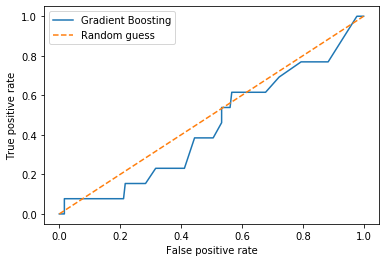

In [15]:
# calculate ROC curve
y_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Gradient Boosting")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [16]:
# Calculate AUC score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.9067357512953368
Precision: 0.14285714285714285
Recall: 0.07692307692307693
F1 score: 0.1


AUC score: 0.4420940170940171
Cross-validation scores: [0.94193548 0.95483871 0.96129032 0.96103896 0.90909091]
Mean cross-validation score: 0.9456388772517805


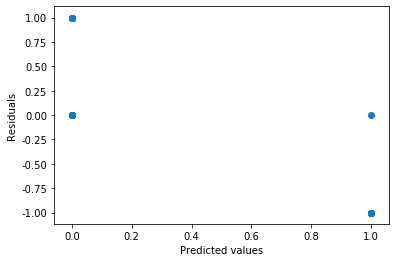

In [17]:
auc_score = roc_auc_score(y_test, y_prob)
print("AUC score:", auc_score)

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
# perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# perform residual analysis
residuals = y_test - y_pred
plt.scatter(model.predict(x_test), residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

## Random Train test split

In [18]:
# x_train, y_train, x_test, y_test = make_random_train_test(course_df, train_ratio = 0.7, random_state = 2)
X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

In [23]:
model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 2, subsample=0.8)
model.fit(x_train, y_train)

GradientBoostingClassifier(random_state=2, subsample=0.8)

In [24]:
model.score(x_test, y_test)

0.9548387096774194

In [25]:
print('In-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_train)[:,1]))
print('Actual number of student dropped: ', np.sum(y_train) )

In-sample prediction:
Expected number of people that will drop:  24.118055816138074
Actual number of student dropped:  24


In [26]:
# Expected number of people that will drop
print('Out-of-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_test)[:,1]))
print('Actual number of student dropped: ', np.sum(y_test) )

Out-of-sample prediction:
Expected number of people that will drop:  7.283048567221444
Actual number of student dropped:  6


In [27]:
# calculate performance metrics
y_pred = model.predict(x_test)
# calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# print confusion matrix
print(f"{'':<10} {'Predicted 0':<15} {'Predicted 1':<15}")
print(f"{'Actual 0':<10} {tn:<15} {fp:<15}")
print(f"{'Actual 1':<10} {fn:<15} {tp:<15}")

           Predicted 0     Predicted 1    
Actual 0   148             1              
Actual 1   6               0              


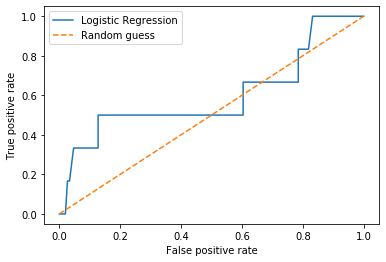

In [28]:
# calculate ROC curve
y_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [29]:
# Calculate AUC score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.9548387096774194
Precision: 0.0
Recall: 0.0
F1 score: 0.0


AUC score: 0.5989932885906041
Cross-validation scores: [0.95483871 0.95483871 0.95483871 0.94155844 0.95454545]
Mean cross-validation score: 0.9521240050272308


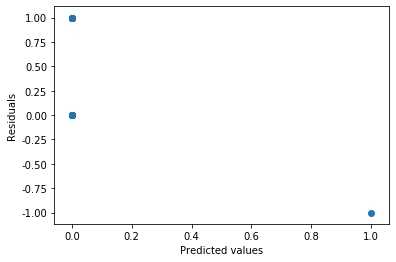

In [30]:
auc_score = roc_auc_score(y_test, y_prob)
print("AUC score:", auc_score)

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
# perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# perform residual analysis
residuals = y_test - y_pred
plt.scatter(model.predict(x_test), residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

## Perform prediction on all useful courses

In [32]:
with open('useful_courses.pkl', 'rb') as f:
    eng_filtered_exams = pickle.load(f)

This will take around 3mins.

In [33]:
# score = []
in_sample_diff = []
out_sample_diff = []
relative_out_sample_diff = [] # difference divided by test size
rnd_in_sample_diff = []
rnd_out_sample_diff = []
for course in eng_filtered_exams:
    course_df = feature_engineer(course)
    x_train, y_train, x_test, y_test = make_semester_specific_train_test(course_df, target_sem = "sp23",
                                                                         past_sems = ["fa22", "sp22"])
    model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 2)
    model.fit(x_train, y_train)
#     score.append(model.score(x_test, y_test))
#     print('In-sample prediction:')
#     print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_train)[:,1]))
#     print('Actual number of student dropped: ', np.sum(y_train) )
    in_sample_diff.append(np.sum(model.predict_proba(x_train)[:,1]) - np.sum(y_train))
    # Expected number of people that will drop
#     print('Out-of-sample prediction:')
#     print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_test)[:,1]))
#     print('Actual number of student dropped: ', np.sum(y_test))
    out_sample_diff.append(np.sum(model.predict_proba(x_test)[:,1]) - np.sum(y_test))
    relative_out_sample_diff.append((np.sum(model.predict_proba(x_test)[:,1]) - np.sum(y_test)) / len(y_test))
    X = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
#     print(y)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
#     x_train, y_train, x_test, y_test = make_random_train_test(course_df, train_ratio = 0.7, random_state = 2)
    model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, random_state = 2)
    model.fit(x_train, y_train)
    rnd_in_sample_diff.append(np.sum(model.predict_proba(x_train)[:,1]) - np.sum(y_train))
    rnd_out_sample_diff.append(np.sum(model.predict_proba(x_test)[:,1]) - np.sum(y_test))

11 students pre-enrolled in AEP-4400
0 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
20 students pre-enrolled in AEP-5400
1 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
71 students pre-enrolled in BEE-5330
1 data point is nan during processing
Sanity check passed
8 students dropped
1 students dropped in the train data
139 students pre-enrolled in BME-2110
0 data point is nan during processing
Sanity check passed
4 students dropped
1 students dropped in the train data
104 students pre-enrolled in BME-3020
0 data point is nan during processing
Sanity check passed
3 students dropped
2 students dropped in the train data
13 students pre-enrolled in BME-3410
0 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
112 students pre-enrolled in CEE-3610
0 data point is nan during processing
Sanity check pas

94 students pre-enrolled in MAE-4510
0 data point is nan during processing
Sanity check passed
12 students dropped
1 students dropped in the train data
24 students pre-enrolled in MAE-4610
1 data point is nan during processing
Sanity check passed
3 students dropped
1 students dropped in the train data
95 students pre-enrolled in MAE-4860
0 data point is nan during processing
Sanity check passed
15 students dropped
4 students dropped in the train data
159 students pre-enrolled in MAE-5010
6 data point is nan during processing
Sanity check passed
13 students dropped
3 students dropped in the train data
19 students pre-enrolled in MAE-5230
1 data point is nan during processing
Sanity check passed
4 students dropped
1 students dropped in the train data
418 students pre-enrolled in MATH-1106
0 data point is nan during processing
Sanity check passed
27 students dropped
2 students dropped in the train data
1203 students pre-enrolled in MATH-1110
4 data point is nan during processing
Sanity ch

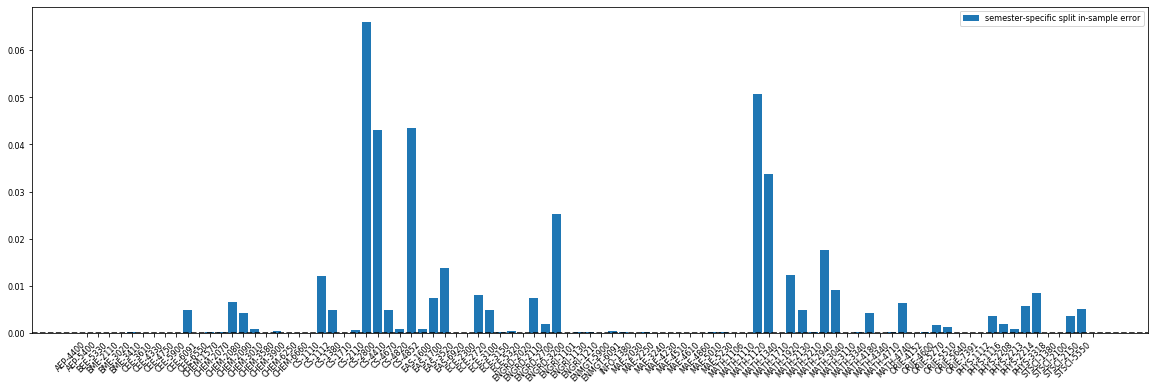

In [34]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(in_sample_diff),
        align = 'center', label = 'semester-specific split in-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

In [35]:
out_sample_diff = np.array(out_sample_diff)
print(f'{sum(out_sample_diff > 0)} courses predict more drops')
print(f'On average, the model predicts {out_sample_diff[out_sample_diff >0].mean()} more drops')
print(f'{sum(out_sample_diff < 0)} courses predict fewer drops')
print(f'On average, the model predicts {-1 * out_sample_diff[out_sample_diff <0].mean()} fewer drops')
print(f'In median, the model predicts {-1 * np.median(out_sample_diff[out_sample_diff <0])} fewer drops')
print(f'Semester-specific Prediction Mean Squared Error (MSE) is {np.mean(out_sample_diff**2)}')

4 courses predict more drops
On average, the model predicts 3.0928035586335776 more drops
87 courses predict fewer drops
On average, the model predicts 16.542731931267458 fewer drops
In median, the model predicts 9.000009502477203 fewer drops
Semester-specific Prediction Mean Squared Error (MSE) is 560.1519643445456


In [36]:
# # create figure and axes objects

# fig, ax1 = plt.subplots(figsize=(20,6))

# # plot first bar plot on the first y-axis
# ax1.bar(np.arange(len(eng_filtered_exams))-0.2, -1 * np.array(out_sample_diff),
#         align='center', label='semester-specific split out-of-sample error', width=0.4, color='C0')
# ax1.set_xticks(range(len(eng_filtered_exams)))
# ax1.set_xticklabels(eng_filtered_exams, rotation=45, ha='right')
# ax1.legend(loc='best')
# ax1.set_ylim(bottom=-10)


# # create second y-axis on the right side of the plot
# ax2 = ax1.twinx()
# # plot second bar plot on the second y-axis
# ax2.bar(np.arange(len(eng_filtered_exams))+0.2, -1* np.array(relative_out_sample_diff)*100,
#         align='center', label='semester-specific split relative out-of-sample error', width=0.4, color='C1')
# ax2.set_ylabel('Relative Error (%)')
# ax2.legend(loc='best', bbox_to_anchor=(0.7, 1))

# # set plot title and axis labels
# ax1.set_title('Comparison of Out-of-Sample Error')
# ax1.set_ylabel('Error')

# # add horizontal line at y=0
# # ax1.axhline(y=0, color='black', linestyle='--')

# plt.show()

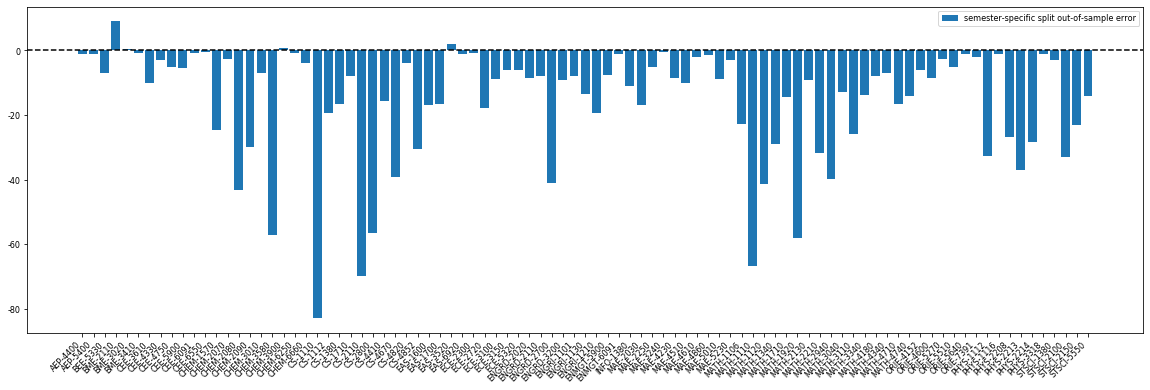

In [37]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(out_sample_diff),
        align = 'center', label = 'semester-specific split out-of-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

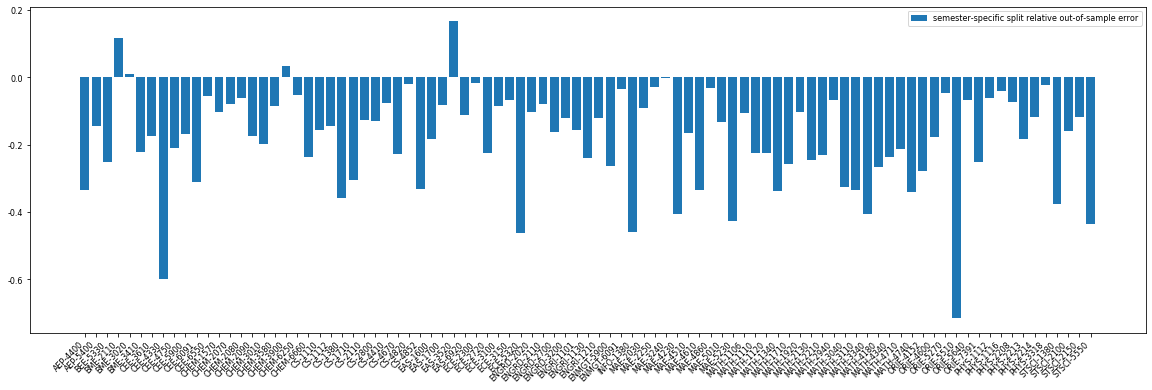

In [38]:
# plt.axhline(y=0, color='black', linestyle='--')
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))
plt.bar(eng_filtered_exams, np.array(relative_out_sample_diff),
        align = 'center', label = 'semester-specific split relative out-of-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

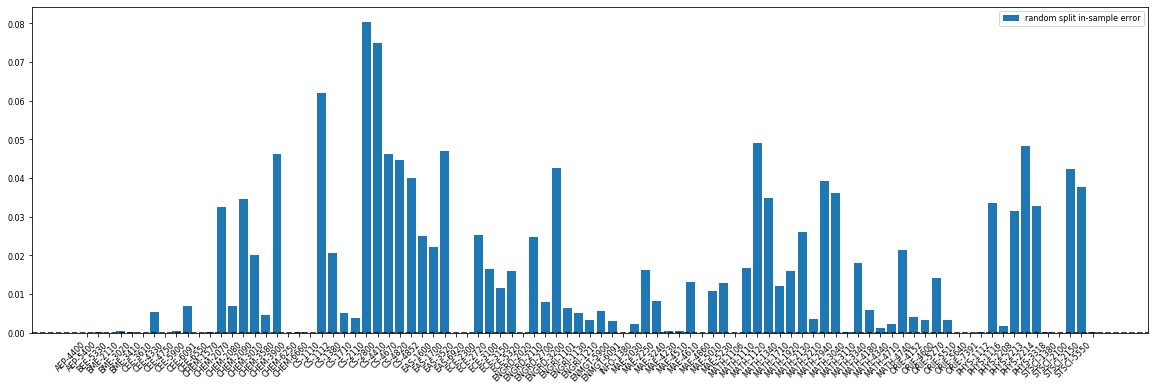

In [39]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(rnd_in_sample_diff),
        align = 'center', label = 'random split in-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

In [40]:
rnd_out_sample_diff = np.array(rnd_out_sample_diff)
print(f'Random Split Prediction Mean Squared Error (MSE) is {np.mean(rnd_out_sample_diff**2)}')

Random Split Prediction Mean Squared Error (MSE) is 1.4615425842126897


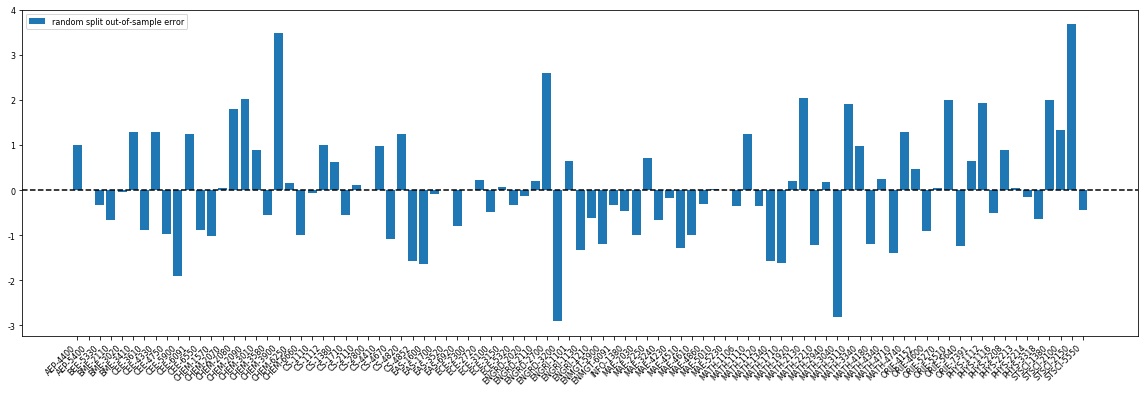

In [41]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(rnd_out_sample_diff),
        align = 'center', label = 'random split out-of-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();